In [3]:
pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a884bb608dd5cb2871f6b1ab2ee1eb05af64f4a0297af76827524d5960a7bf4a
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [4]:
pip install pyoselm

  Preparing metadata (setup.py) ... done
Discarding https://files.pythonhosted.org/packages/56/c6/0914a51aea89064725cec9b9ad92adb77d8ae6b03dd369b00641369aae79/pyoselm-1.0.1-2.tar.gz (from https://pypi.org/simple/pyoselm/): Requested pyoselm from https://files.pythonhosted.org/packages/56/c6/0914a51aea89064725cec9b9ad92adb77d8ae6b03dd369b00641369aae79/pyoselm-1.0.1-2.tar.gz has inconsistent version: expected '1.0.1.post2', but metadata has '1.0.1'



📘 X_train_scaled (first 5 rows):
        BVP       EDA      TEMP      AccX      AccY      AccZ        HR  \
0 -0.236276 -0.708252 -1.023767  1.591055 -1.029676  1.056229 -0.514252   
1  1.095257  0.592021  0.103095 -1.077047  0.968156 -0.320707  1.334348   
2  0.127289  0.599888  1.245979 -1.264282 -0.167866 -0.891632 -0.769734   
3 -0.525128 -0.668819  0.722602 -0.562150 -1.108023  0.015131  0.376534   
4  0.985385 -0.682799  0.017646 -1.123855 -0.324559 -0.555793  0.192937   

      Delta     Theta    Alpha1    Alpha2     Beta1     Beta2    Gamma1  \
0  1.259641 -0.371131  0.676199 -0.566670  0.575726 -0.635747 -0.516289   
1 -0.646587 -0.381736  1.718746  0.115653  0.508169 -0.258007 -0.336352   
2 -0.613363  0.588219 -0.732973 -0.614810  0.875468  1.833919  4.914687   
3 -0.047946 -0.257798  1.650485 -0.696863  0.262133  0.317078  0.218833   
4  0.200207  0.346404  0.337054 -0.298132 -0.712601  1.091021 -0.577340   

     Gamma2   Attention   Meditation  
0  0.613758    0.279794  

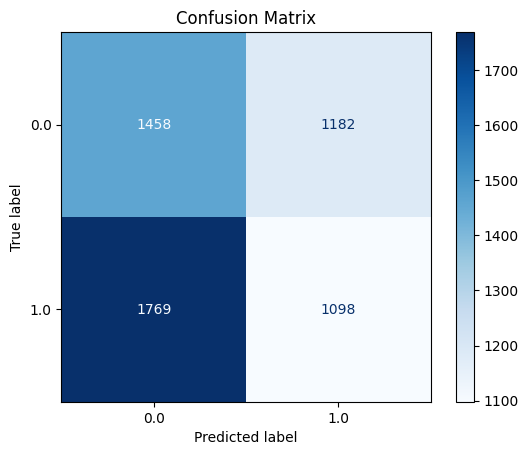

   Sample  Predicted_Class  Uncertainty (1 - max prob)
0       0              1.0                         0.0
1       1              1.0                         0.0
2       2              0.0                         0.0
3       3              1.0                         0.0
4       4              0.0                         0.0


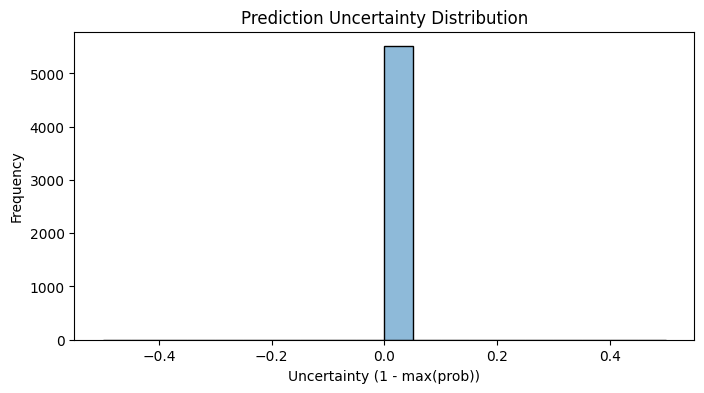

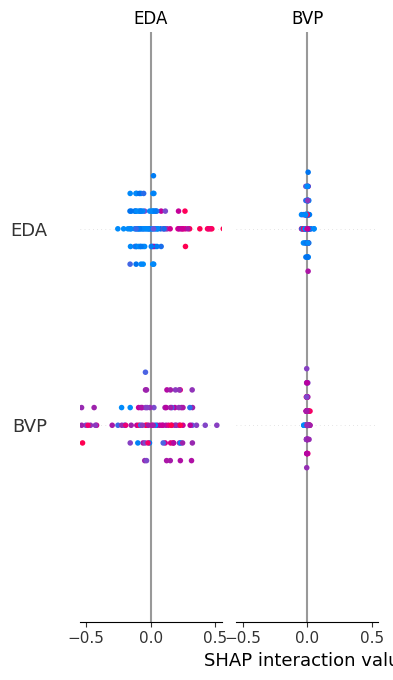


🟡 LIME Explanation for First Sample:
[('EDA <= -0.66', -0.16797295793862707), ('TEMP > 0.75', 0.10720461956327397), ('HR > 0.59', -0.05559966843414688), ('AccZ <= -0.62', -0.05261855796409514), ('AccX > 0.56', -0.03553605481538519), ('-0.05 < AccY <= 0.50', 0.02265155542852361), (' Beta2 <= -0.64', -0.01483338235468123), (' Alpha1 > 0.26', -0.010165265775742421), ('-0.64 <  Alpha2 <= -0.38', 0.007344153958078611), ('-0.39 <  Beta1 <= 0.27', -0.006951678136117558)]

✅ Results saved to 'OSELM_Model_Results.xlsx'


In [10]:
# oselm_uncertainty_xai.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from lime.lime_tabular import LimeTabularExplainer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)

from scipy.special import softmax
from scipy.linalg import pinv
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import as_float_array

import warnings
warnings.filterwarnings("ignore")


class SimpleRandomLayer:
    def __init__(self, n_hidden=100, activation_func="sigmoid", random_state=None):
        self.n_hidden = n_hidden
        self.activation_func = activation_func
        self.random_state = np.random.RandomState(random_state)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit_transform(self, X):
        self.input_weights = self.random_state.uniform(-1., 1., (X.shape[1], self.n_hidden))
        self.biases = self.random_state.uniform(-1., 1., (self.n_hidden,))
        H = X @ self.input_weights + self.biases
        return self._sigmoid(H)


class OSELMClassifier:
    def __init__(self, n_hidden=100, activation_func="sigmoid", random_state=0):
        self.n_hidden = n_hidden
        self.activation_func = activation_func
        self.random_state = random_state
        self.layer = SimpleRandomLayer(n_hidden, activation_func, random_state)
        self.binarizer = LabelBinarizer(neg_label=0, pos_label=1)
        self.beta = None
        self.P = None

    def fit(self, X, y):
        y_bin = self.binarizer.fit_transform(y)
        H = self.layer.fit_transform(X)
        self.P = pinv(H.T @ H)
        self.beta = self.P @ H.T @ y_bin
        self.classes_ = self.binarizer.classes_
        return self

    def predict(self, X):
        H = self.layer.fit_transform(X)
        output = H @ self.beta
        return self.binarizer.inverse_transform(output)

    def predict_proba(self, X):
        H = self.layer.fit_transform(X)
        raw_output = H @ self.beta
        # Ensure output is 2D for softmax, even for binary classification
        if raw_output.ndim == 1:
            raw_output = raw_output.reshape(-1, 1)
        return softmax(raw_output, axis=1)


def compute_uncertainty(probs):
    return 1 - np.max(probs, axis=1)


def main():
    data = pd.read_csv("/content/drive/MyDrive/CODE/Prince Okyere/DOWN/MEFAR_DOWN.csv")
    data.dropna(inplace=True)
    label_encoder = LabelEncoder()
    data['class'] = label_encoder.fit_transform(data['class'])
    classes = label_encoder.classes_.astype(str)

    X = data.drop('class', axis=1)
    y = data['class']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    oselm = OSELMClassifier(n_hidden=100, activation_func="sigmoid", random_state=0)
    oselm.fit(X_train_scaled, y_train)
    y_pred_class = oselm.predict(X_test_scaled)
    y_pred_prob = oselm.predict_proba(X_test_scaled)

    # Ensure y_pred_prob is 2D for DataFrame creation, especially for binary cases
    if y_pred_prob.ndim == 1:
         # For binary classification, reshape to (n_samples, 1)
        y_pred_prob = y_pred_prob.reshape(-1, 1)

    # Convert scaled features back to DataFrames for readable display
    X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

    # Convert predicted class and probability to DataFrames
    y_pred_class_df = pd.DataFrame({"Predicted Class": label_encoder.inverse_transform(y_pred_class)}) # Inverse transform here for readability

    # Determine column names based on the shape of y_pred_prob
    if y_pred_prob.shape[1] == len(label_encoder.classes_):
        prob_columns = [f"Class_{cls}" for cls in label_encoder.classes_]
    elif y_pred_prob.shape[1] == 1 and len(label_encoder.classes_) == 2:
        # Binary case where only probability of positive class is returned
        # Assuming the second class in label_encoder.classes_ is the positive class
        positive_class_name = label_encoder.classes_[1]
        prob_columns = [f"Class_{positive_class_name}_Prob"]
    else:
        # Fallback for unexpected shapes
        prob_columns = [f"Prob_{i}" for i in range(y_pred_prob.shape[1])]


    y_pred_prob_df = pd.DataFrame(
        y_pred_prob,
        columns=prob_columns
    )

    # Display first 5 rows of each DataFrame for clarity
    print("\n📘 X_train_scaled (first 5 rows):")
    print(X_train_df.head())

    print("\n📗 X_test_scaled (first 5 rows):")
    print(X_test_df.head())

    print("\n📙 Predicted Classes (first 5):")
    print(y_pred_class_df.head())

    print("\n📕 Predicted Probabilities (first 5 rows):")
    print(y_pred_prob_df.head())


    acc = accuracy_score(y_test, y_pred_class)
    prec = precision_score(y_test, y_pred_class, average='weighted')
    rec = recall_score(y_test, y_pred_class, average='weighted')
    f1 = f1_score(y_test, y_pred_class, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred_class)
    report = classification_report(y_test, y_pred_class, target_names=classes)
    cm = confusion_matrix(y_test, y_pred_class)

    print("\n📊 Classification Report:\n", report)

    youden_index = np.nan
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall_score(y_test, y_pred_class)
        youden_index = sensitivity + specificity - 1

    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    uncertainties = compute_uncertainty(y_pred_prob)
    uncertainty_df = pd.DataFrame({
        "Sample": np.arange(len(uncertainties)),
        "Predicted_Class": label_encoder.inverse_transform(y_pred_class),
        "Uncertainty (1 - max prob)": uncertainties
    })
    print(uncertainty_df.head())

    plt.figure(figsize=(8, 4))
    sns.histplot(uncertainties, bins=20, kde=True)
    plt.title("Prediction Uncertainty Distribution")
    plt.xlabel("Uncertainty (1 - max(prob))")
    plt.ylabel("Frequency")
    plt.show()

    rf = RandomForestClassifier()
    rf.fit(X_train_scaled, y_train)

    explainer = shap.Explainer(rf, X_train_scaled)
    shap_values = explainer(X_test_scaled[:100])
    shap.summary_plot(shap_values, X_test.iloc[:100], show=True)

    lime_exp = LimeTabularExplainer(X_train_scaled, feature_names=X.columns,
                                    class_names=classes, discretize_continuous=True)
    lime_result = lime_exp.explain_instance(X_test_scaled[0], rf.predict_proba, num_features=10)
    print("\n🟡 LIME Explanation for First Sample:")
    print(lime_result.as_list())

    results_df = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Youden Index"],
        "Value": [acc, prec, rec, f1, mcc, youden_index]
    })
    results_df.to_excel("OSELM_Model_Results.xlsx", index=False)
    print("\n✅ Results saved to 'OSELM_Model_Results.xlsx'")


if __name__ == "__main__":
    main()